## Description

### This file is used for spliting the dataset, and it will consist of the following subset:
- image
  - {frame_id}.png        # Rendered image of a face
- label
  - {frame_id}_seg.png     # Segmentation image, where each pixel has an integer value mapping to the categories below
- ldmks
  - {frame_id}_ldmks.txt    # Landmark annotations for 70 facial landmarks (x, y) coordinates for every row

In [27]:
import os
import cv2
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [17]:
# Define the dataset path and target folder
ROOT_PATH = 'D:\sythetic_data'
DATASET_NAME ='dataset_100'# choose the dataset 
DATASET_PATH = os.path.join(ROOT_PATH, DATASET_NAME)
IMAGE_FOLDER = os.path.join(DATASET_PATH, 'image')
LABEL_FOLDER = os.path.join(DATASET_PATH, 'label')
LDMKS_FOLDER = os.path.join(DATASET_PATH, 'ldmks')

In [18]:
# If the destination folder does not exist, create it
os.makedirs(IMAGE_FOLDER, exist_ok=True)
os.makedirs(LABEL_FOLDER, exist_ok=True)
os.makedirs(LDMKS_FOLDER, exist_ok=True)

In [19]:
# Traverse all files in the dataset folder
for filename in os.listdir(DATASET_PATH):
    file_path = os.path.join(DATASET_PATH, filename)
    
    # Check if it is a file (ignore folders)
    if os.path.isfile(file_path):
        # If the file name matches the image file format
        if filename.endswith('.png')and not filename.endswith('_seg.png'):
            shutil.move(file_path, os.path.join(IMAGE_FOLDER, filename))
        
        # If the file name matches the mask file format
        elif filename.endswith('_seg.png'):
            shutil.move(file_path, os.path.join(LABEL_FOLDER, filename))
            
        # If the file name matches the ldmks file formaty
        elif filename.endswith('_ldmks.txt'):
            shutil.move(file_path, os.path.join(LDMKS_FOLDER, filename))

###  Analyze the class distribution in the mask image and takes one image as an example :

In [23]:
IMG_WIDTH = 512
IMG_HEIGHT = 512

In [20]:
image_id = '000000'
image_name = image_id + ".png"
mask_name = image_id + "_seg.png"
image_path = os.path.join(IMAGE_FOLDER, image_name)
mask_path = os.path.join(LABEL_FOLDER, mask_name)

In [32]:
# show a image-mask pairs
def showImg(image_path, mask_path):
    img = cv2.imread(image_path, cv2.COLOR_BGR2GRAY)
    mask = cv2.imread(mask_path, cv2.COLOR_BGR2GRAY)
    print("img_size:", img.shape[:2] )
    print("mask_size:", mask.shape[:2] )
    mask = np.stack((mask,)*3, axis=-1)
    mid = np.zeros((IMG_HEIGHT, 50, 3))
    tmp = np.concatenate((img, mid), axis = 1)
    show_img = np.concatenate((tmp, mask), axis = 1)
    show_img = show_img.astype(np.uint8)
    plt.imshow(show_img)
    plt.show()

img_size: (512, 512)
mask_size: (512, 512)


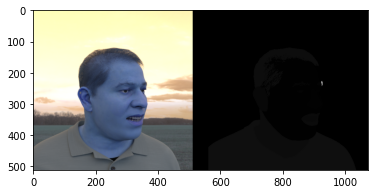

In [33]:
showImg(image_path, mask_path)

In [31]:
# Open the mask image and convert it into an numpy array
mask_example = Image.open(mask_path)
mask_array = np.array(mask_example)

In [34]:
# Print all unique values (category labels)
print("class label: ", np.unique(mask_array))

class label:  [  0   1   2   3   4   5   6   8   9  10  11  12  13  15 255]
